In [345]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.
[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


In [346]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer,confusion_matrix,ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier

In [347]:
df = pd.read_csv('data/heart_disease_health_indicators_BRFSS2015.csv')
X = df.loc[:,df.columns!='HeartDiseaseorAttack']
y = df['HeartDiseaseorAttack']

In [348]:
ordinal_ftrs = ['Diabetes','Education','Income','GenHlth','MentHlth','PhysHlth','Age']
ordinal_cats = [[0,1,2],[1,2,3,4,5,6],[1,2,3,4,5,6,7,8],[1,2,3,4,5],\
                [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],\
                [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],\
                [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]
onehot_ftrs = ['HighBP','HighChol','CholCheck','Smoker','Stroke','PhysActivity','Fruits',\
               'Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','DiffWalk','Sex']
std_ftrs = ['BMI']

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

In [548]:
random_state = 7
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.02,stratify=y,random_state=random_state)

neg = len(y[y==0])
pos = len(y[y==1])

rec = 1
pre = pos/(pos+neg)

#baseline f2 score
base_f2 = fbeta_score(y,np.ones(y.shape),beta=2)
print(base_f2)

0.3420596016629826


In [350]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [351]:
def MLpipe_StratKFold_fbeta2(X, y, preprocessor, ML_algo, param_grid):  
    train_scores = []
    val_scores = []
    best_models = []

    for random_state in range(10):
        X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.95,stratify=y,random_state=random_state)
        skf=StratifiedKFold(n_splits=4,shuffle=True,random_state=random_state)

        pipe = make_pipeline(preprocessor,StandardScaler(),ML_algo)

        grid = GridSearchCV(pipe,param_grid=param_grid,scoring=f2_scorer,cv=skf,
                            return_train_score=True,n_jobs=7,verbose=2)
        grid.fit(X_train,y_train)
        best_models.append(grid)
    
        y_train_pred = grid.predict(X_train)
        y_val_pred = grid.predict(X_val)
        
        train_scores.append(fbeta_score(y_train,y_train_pred,beta=2))
        val_scores.append(fbeta_score(y_val,y_val_pred,beta=2))
  
    return train_scores, val_scores, best_models

Fitting 4 folds for each of 10 candidates, totalling 40 fits


179205.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179205.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179205.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179205.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179205.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179205.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
179205.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugge

[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   4.1s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   4.0s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   4.4s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   4.5s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   4.9s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   5.2s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   5.7s
[CV] END logisticregression__C=0.1, logisticregression__class_weight=None; total time=   3.9s
[CV] END logisticregression__C=0.1, logisticregression__class_weight=None; total time=   3.6s
[CV] END logisticregression__C=0.1, logisticregression__class_weight=None; total time=   3.9s
[CV] END logisticregression__C=0.1, logis

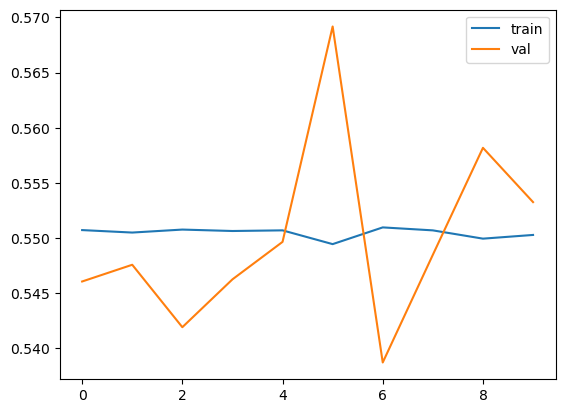

In [554]:
lr_l1_clf = LogisticRegression(penalty='l1',solver='saga',
                         random_state=random_state)
param_grid = {'logisticregression__C':np.logspace(-2,2,5),
             'logisticregression__class_weight':[None,'balanced']}

lr_l1_train_scores, lr_l1_val_scores, lr_l1_best_models = MLpipe_StratKFold_fbeta2(X_other,y_other,preprocessor,
                                                                           lr_l1_clf,param_grid)

print('mean max f-beta 2 train:',np.mean(lr_l1_train_scores))
print('std max f-beta 2 train:',np.std(lr_l1_train_scores))
print(lr_l1_train_scores)
print('mean max f-beta 2 val:',np.mean(lr_l1_val_scores))
print('std max f-beta 2 val:',np.std(lr_l1_val_scores))
print(lr_l1_val_scores)

plt.plot(range(10),lr_l1_train_scores,label='train')
plt.plot(range(10),lr_l1_val_scores,label='val')
plt.legend()
plt.show()

In [ ]:
file = open('results/lr_l1_grid.save', 'wb')
pickle.dump((lr_l1_train_scores, lr_l1_val_scores, lr_l1_best_models),file)
file.close()

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   2.9s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   3.1s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   3.0s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   3.1s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   3.3s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   3.0s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   3.0s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   3.4s
[CV] END logisticregression__C=0.1, logisticregression__class_weight=None; total time=   2.9s
[CV] END logisticregression__C=0.1, logisticregression__class_weight=

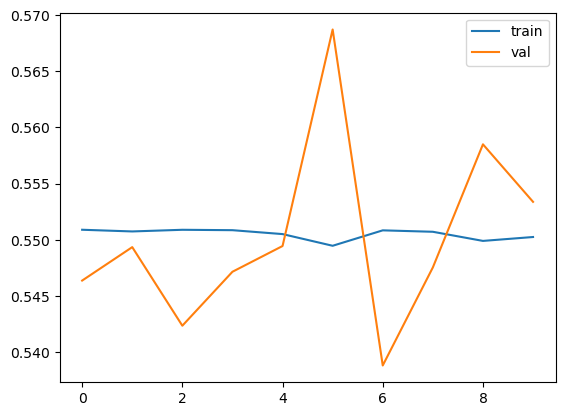

In [ ]:
lr_clf = LogisticRegression(penalty='l2',solver='lbfgs',
                         random_state=random_state)
param_grid = {'logisticregression__C':np.logspace(-2,2,5),
             'logisticregression__class_weight':[None,'balanced']}

lr_train_scores, lr_val_scores, lr_best_models = MLpipe_StratKFold_fbeta2(X_other,y_other,preprocessor,
                                                                           lr_clf,param_grid)

print('mean max f-beta 2 train:',np.mean(lr_train_scores))
print('std max f-beta 2 train:',np.std(lr_train_scores))
print(lr_train_scores)
print('mean max f-beta 2 val:',np.mean(lr_val_scores))
print('std max f-beta 2 val:',np.std(lr_val_scores))
print(lr_val_scores)

plt.plot(range(10),lr_train_scores,label='train')
plt.plot(range(10),lr_val_scores,label='val')
plt.legend()
plt.show()

In [ ]:
file = open('results/lr_grid.save', 'wb')
pickle.dump((lr_train_scores, lr_val_scores, lr_best_models),file)
file.close()

In [543]:
file = open('results/lr_l1_grid.save', 'rb')
lr_l1_train_scores, lr_l1_val_scores, lr_l1_best_models = pickle.load(file)
file.close()

file = open('results/lr_grid.save', 'rb')
lr_train_scores, lr_val_scores, lr_best_models = pickle.load(file)
file.close()

file = open('results/rfc_grid.save', 'rb')
rfc_train_scores, rfc_val_scores, rfc_best_models = pickle.load(file)
file.close()

file = open('results/xgb_depth_grid.save', 'rb')
xgb_train_scores, xgb_val_scores, xgb_best_models = pickle.load(file)
file.close()

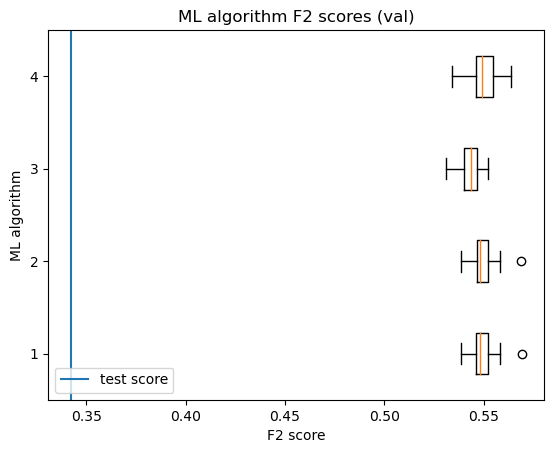

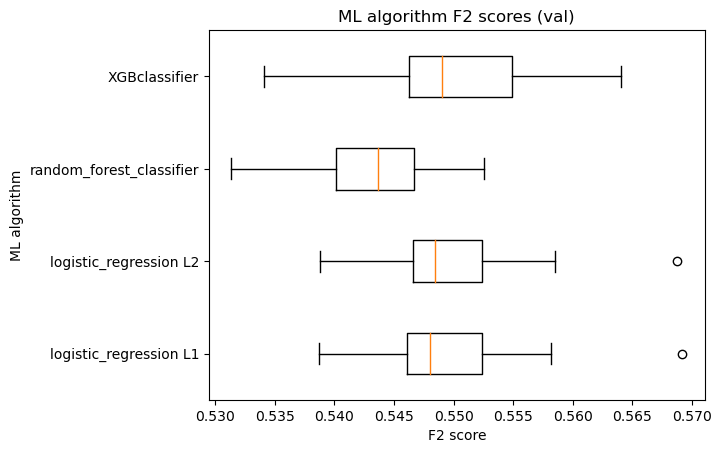

In [550]:
val_scores = [lr_l1_val_scores, lr_val_scores, rfc_val_scores, xgb_val_scores]

plt.boxplot(val_scores, vert=False)
plt.xlabel('F2 score')
plt.ylabel('ML algorithm')
plt.yticks([1,2,3,4],['logistic_regression L1','logistic_regression L2',
             'random_forest_classifier','XGBclassifier'])
plt.axvline(base_f2,label='test score')
plt.title('ML algorithm F2 scores (val)')
plt.legend(loc='lower left')
plt.savefig('f2 scores (val).png', dpi=300,bbox_inches='tight')
plt.show()

plt.boxplot(val_scores, vert=False)
plt.xlabel('F2 score')
plt.ylabel('ML algorithm')
plt.yticks([1,2,3,4],['logistic_regression L1','logistic_regression L2',
             'random_forest_classifier','XGBclassifier'])
plt.title('ML algorithm F2 scores (val)')
plt.savefig('f2 scores (val) no base.png', dpi=300,bbox_inches='tight')
plt.show()

In [545]:
def get_test_scores(X_test, y_test, models):
    test_scores = []
    for model in models:
         test_scores.append(fbeta_score(y_test, model.predict(X_test),beta=2))
    return test_scores

In [547]:
lr_l1_test_scores = get_test_scores(X_test,y_test,lr_l1_best_models)
lr_test_scores = get_test_scores(X_test,y_test,lr_best_models)
rfc_test_scores = get_test_scores(X_test,y_test,rfc_best_models)
xgb_test_scores = get_test_scores(X_test,y_test,xgb_best_models)

In [553]:
def mean_std_base(test_scores,name):
    mean_score = np.mean(test_scores)
    std_score = np.std(test_scores)
    print(name+" mean:",mean_score)
    print(name+" std:",std_score)
    print(name+" stds above base:", (mean_score/base_f2)/std_score)

mean_std_base(lr_l1_test_scores, "lr l1")
mean_std_base(lr_test_scores, "lr l2")
mean_std_base(rfc_test_scores, "rfc")
mean_std_base(xgb_test_scores, "xgb")

lr l1 mean: 0.5626397551883574
lr l1 std: 0.0008732213182946027
lr l1 stds above base: 1883.6677399362788
lr l2 mean: 0.5628538194869872
lr l2 std: 0.0009952542001481623
lr l2 stds above base: 1653.3310151223006
rfc mean: 0.5509180244110996
rfc std: 0.003922290376839956
rfc stds above base: 410.6250628560036
xgb mean: 0.5561163009190012
xgb std: 0.0027759674888347785
xgb stds above base: 585.6652606855674


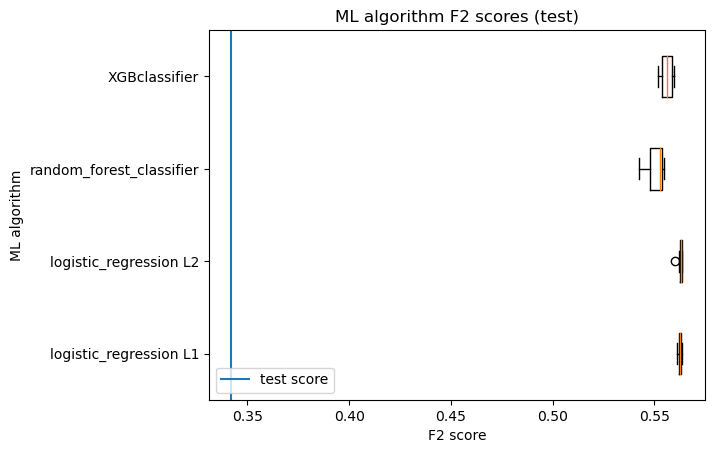

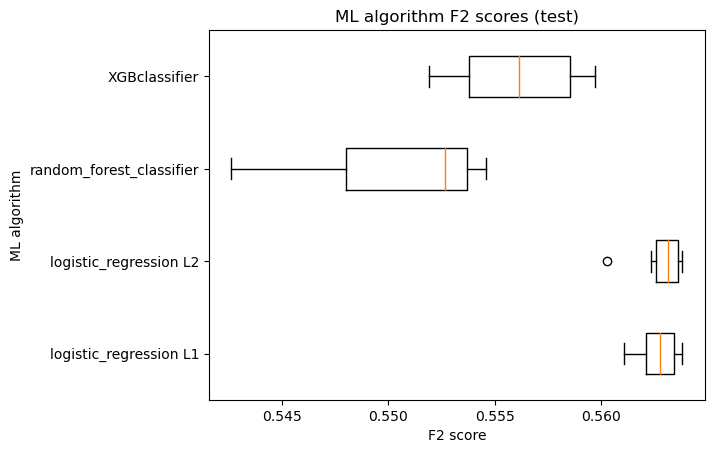

In [491]:
test_scores = [lr_l1_test_scores, lr_test_scores, rfc_test_scores, xgb_test_scores]

plt.boxplot(test_scores, vert=False)
plt.xlabel('F2 score')
plt.ylabel('ML algorithm')
plt.yticks([1,2,3,4],['logistic_regression L1','logistic_regression L2',
             'random_forest_classifier','XGBclassifier'])
plt.axvline(base_f2,label='test score')
plt.title('ML algorithm F2 scores (test)')
plt.legend(loc='lower left')
plt.savefig('f2 scores (test).png', dpi=300,bbox_inches='tight')
plt.show()

plt.boxplot(test_scores, vert=False)
plt.xlabel('F2 score')
plt.ylabel('ML algorithm')
plt.yticks([1,2,3,4],['logistic_regression L1','logistic_regression L2',
             'random_forest_classifier','XGBclassifier'])
plt.title('ML algorithm F2 scores (test)')
plt.savefig('f2 scores (test) no base.png', dpi=300,bbox_inches='tight')
plt.show()

In [492]:
rfc_clf = RandomForestClassifier(n_estimators=10,random_state=random_state,verbose=True)
param_grid = {'randomforestclassifier__max_depth': [None,1,10,100],
              'randomforestclassifier__max_features': [None,0.33,0.66,1.0],
              'randomforestclassifier__class_weight': [None,'balanced','balanced_subsample']}

rfc_train_scores, rfc_val_scores, rfc_best_models = MLpipe_StratKFold_fbeta2(X_other,y_other,preprocessor,
                                                                              rfc_clf,param_grid)

print('mean max f-beta 2 train:',np.mean(rfc_train_scores))
print('std max f-beta 2 train:',np.std(rfc_train_scores))
print(rfc_train_scores)
print('mean max f-beta 2 val:',np.mean(rfc_val_scores))
print('std max f-beta 2 val:',np.std(rfc_val_scores))
print(rfc_val_scores)

plt.plot(range(10),rfc_train_scores,label='train')
plt.plot(range(10),rfc_val_scores,label='val')
plt.legend()
plt.show()

Fitting 4 folds for each of 48 candidates, totalling 192 fits


167027.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
167027.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
167027.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
167027.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
167027.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
167027.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
167027.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugge

[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.33; total time=   6.4s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.33; total time=   6.6s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.33; total time=   6.6s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=None; total time=  13.1s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=None; total time=  13.2s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.33; total time=   5.6s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__

KeyboardInterrupt: 

In [ ]:
file = open('results/rfc_grid.save', 'wb')
pickle.dump((rfc_train_scores, rfc_val_scores, rfc_best_models),file)
file.close()

Fitting 4 folds for each of 54 candidates, totalling 216 fits


129061.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugge

[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time=   9.6s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time=   9.9s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=  10.0s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=  10.0s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=  10.1s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=  10.1s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
130219.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.2min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.7min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 3.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 3.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.7min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.7min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xg

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
132612.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 3.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.7min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.5min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.5min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=1.0, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time= 2.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=1.0,

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
134600.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 3.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 3.0min


134615.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
134616.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 3.0min


134711.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 2.8min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 2.8min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xg

134841.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 2.8min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.5min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.5min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=1.0, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time= 2.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.5min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=1.0,

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
136720.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 2.9min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 2.9min


136732.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 2.9min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbcl

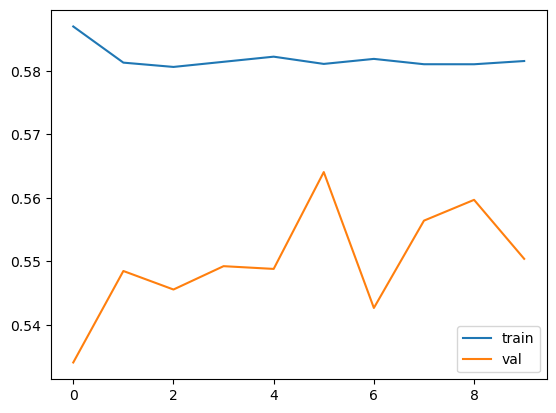

In [484]:
xgb_clf = xgboost.XGBClassifier(learning_rate=0.03,missing=np.nan, 
                                seed=random_state, colsample_bytree=0.9, subsample=0.66)

param_grid = {"xgbclassifier__reg_alpha": np.logspace(-1,1,3),
              "xgbclassifier__reg_lambda": np.logspace(-1,1,3),
              "xgbclassifier__max_depth": [1,10,100],
              "xgbclassifier__scale_pos_weight":[1,10]}

xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

#NEED TO HAVE EVAL_SET TO DO LEARNING_RATE
xgb_train_scores, xgb_val_scores, xgb_best_models = MLpipe_StratKFold_fbeta2(X_other,y_other,
                                                                             preprocessor,xgb_clf,
                                                                             param_grid)
# MLpipe__fbeta2(X_other,y_other,preprocessor,param_grid)

print('mean max f-beta 2 train:',np.mean(xgb_train_scores))
print('std max f-beta 2 train:',np.std(xgb_train_scores))
print(xgb_train_scores)
print('mean max f-beta 2 val:',np.mean(xgb_val_scores))
print('std max f-beta 2 val:',np.std(xgb_val_scores))
print(xgb_val_scores)

plt.plot(range(10),xgb_train_scores,label='train')
plt.plot(range(10),xgb_val_scores,label='val')
plt.legend()
plt.show()

In [485]:
file = open('results/xgb_depth_grid.save', 'wb')
pickle.dump((xgb_train_scores, xgb_val_scores, xgb_best_models),file)
file.close()

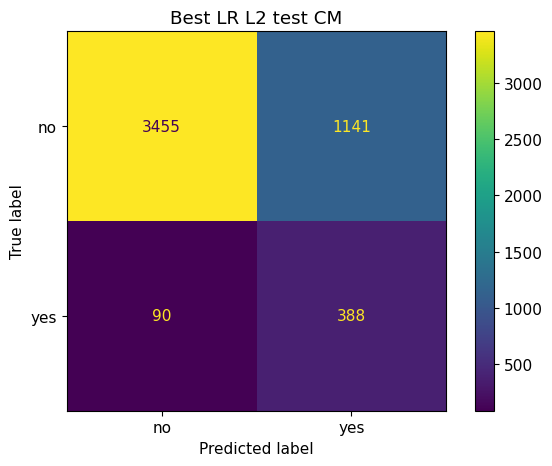

0.5637895960476607


In [ ]:
best_test_model = lr_best_models[np.argmax(lr_test_scores)]

test_cf = confusion_matrix(y_test,best_test_model.predict(X_test))
disp = ConfusionMatrixDisplay(test_cf,display_labels=['no', 'yes'])
fig, ax = plt.subplots()
disp.plot(ax=ax)
plt.title('Best LR L2 test CM')
plt.tight_layout()
plt.savefig('lr l2 cm',dpi=300,bbox_inches='tight')
plt.show()

print(lr_test_scores[np.argmax(lr_test_scores)])

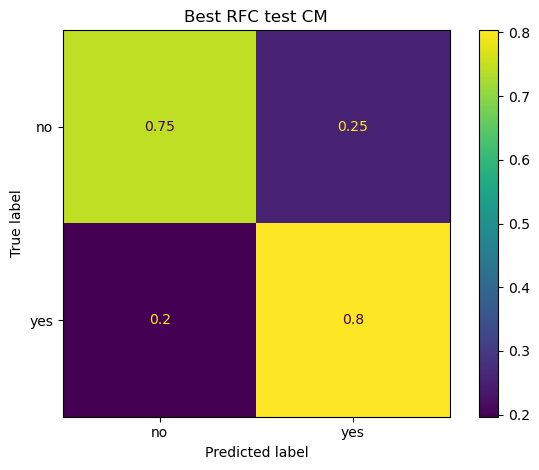

0.5545927209705372


In [ ]:
best_test_model = rfc_best_models[np.argmax(rfc_test_scores)]

test_cf = confusion_matrix(y_test,best_test_model.predict(X_test),normalize='true')
disp = ConfusionMatrixDisplay(test_cf,display_labels=['no', 'yes'])
fig, ax = plt.subplots()
disp.plot(ax=ax)
plt.title('Best RFC test CM')
plt.tight_layout()
plt.savefig('rfc cm',dpi=300,bbox_inches='tight')
plt.show()

print(rfc_test_scores[np.argmax(rfc_test_scores)])

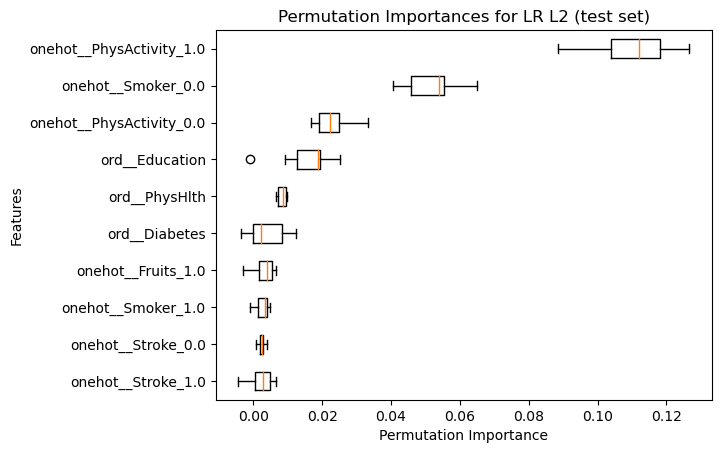

In [568]:
models = lr_best_models
test_scores = lr_test_scores
perm_imp = permutation_importance(models[np.argmax(test_scores)],X_test,y_test,scoring=f2_scorer,
                       random_state=random_state,n_repeats=10)
importances = perm_imp.importances_mean
importances_raw = perm_imp.importances

sorted_indices = np.argsort(importances)[-10:] 
col_names = models[np.argmax(test_scores)].best_estimator_[:-1].get_feature_names_out()
# labels=col_names[sorted_indices]

plt.boxplot(importances_raw[sorted_indices].T,labels=col_names[sorted_indices],vert=False)
plt.title("Permutation Importances for LR L2 (test set)")
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.savefig('perm imp lr l2.png',dpi=300,bbox_inches='tight')
plt.show()

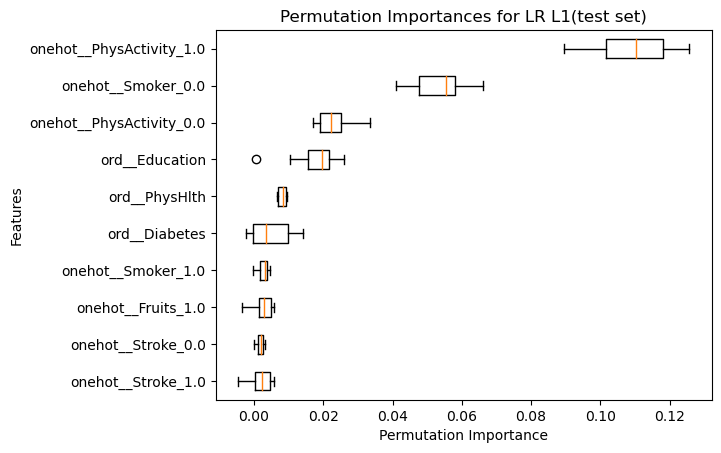

In [ ]:
models = lr_l1_best_models
test_scores = lr_l1_test_scores
perm_imp = permutation_importance(models[np.argmax(test_scores)],X_test,y_test,scoring=f2_scorer,
                       random_state=random_state,n_repeats=10)
importances = perm_imp.importances_mean
importances_raw = perm_imp.importances

sorted_indices = np.argsort(importances)[-10:] 
col_names2 = models[np.argmax(test_scores)].best_estimator_[:-1].get_feature_names_out()

plt.boxplot(importances_raw[sorted_indices].T,labels=col_names2[sorted_indices],vert=False)
plt.title("Permutation Importances for LR L1(test set)")
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.savefig('perm imp lr l1.png',dpi=300,bbox_inches='tight')
plt.show()

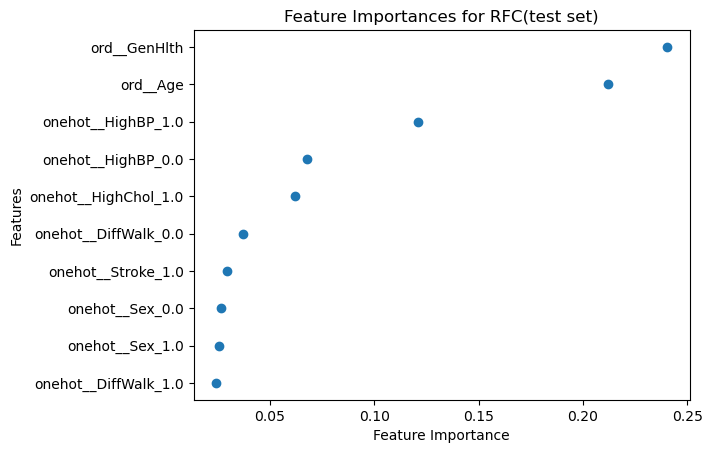

In [ ]:
models = rfc_best_models
test_scores = rfc_test_scores

importances = models[np.argmax(rfc_test_scores)].best_estimator_[-1].feature_importances_

sorted_indices = np.argsort(importances)[-10:] 
col_names = models[np.argmax(rfc_test_scores)].best_estimator_[:-1].get_feature_names_out()

plt.scatter(importances[sorted_indices],range(10))
plt.title("Feature Importances for RFC(test set)")
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.yticks(range(10),col_names[sorted_indices])
plt.savefig('feature imp RFC.png',dpi=300,bbox_inches='tight')
plt.show()

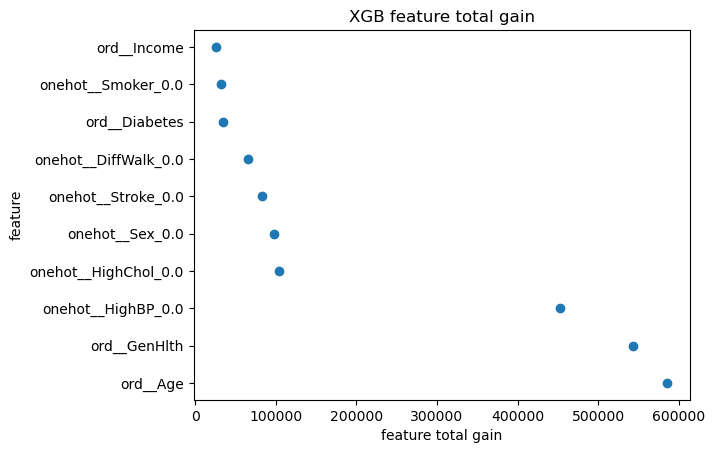

In [ ]:
models = xgb_best_models
test_scores = xgb_test_scores

gains = models[np.argmax(rfc_test_scores)].best_estimator_[-1].get_booster()\
                .get_score(importance_type='total_gain')

sorted_gains = sorted(gains.items(),key=lambda item:item[1])[-1:-11:-1]
x,y = zip(*sorted_gains)
plt.scatter(y,x)
plt.xlabel('feature total gain')
plt.ylabel('feature')
plt.title('XGB feature total gain')
plt.yticks(['f2','f13','f0','f29','f15','f31','f9','f7','f3','f6'],
            col_names[[2,13,0,29,15,31,9,7,3,6]])
plt.savefig('total gain XGB.png',dpi=300,bbox_inches='tight')
plt.show()

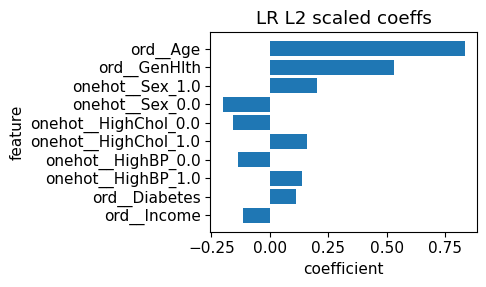

In [ ]:
coefs = lr_best_models[np.argmax(lr_test_scores)].best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

col_names = models[np.argmax(test_scores)].best_estimator_[:-1].get_feature_names_out()

plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 11})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),col_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('LR L2 scaled coeffs')
plt.tight_layout()
plt.savefig('LR l2 scaled coefs.png',dpi=300)
plt.show()

In [733]:
import shap

grid = lr_best_models[np.argmax(lr_test_scores)]

shap.initjs()

X_test_transformed = grid.best_estimator_[1].transform(grid.best_estimator_[0].transform(X_test))
print(np.shape(X_test_transformed))

def model_predict_proba(x):
    return grid.best_estimator_[2].predict_proba(x)

def model__log_odds(x):
    p = grid.best_estimator_[2].predict_log_proba(x)
    return p[:, 1] - p[:, 0]

explainer = shap.Explainer(model_predict_proba,X_test_transformed[:])

shap_values = explainer(X_test_transformed[:]).values
print(np.shape(shap_values))
print(shap_values)

(5074, 34)


Permutation explainer: 5075it [00:34, 104.13it/s]                          


(5074, 34, 2)
[[[ 1.33123035e-02 -1.33123035e-02]
  [ 4.72819195e-04 -4.72819195e-04]
  [ 2.02285025e-02 -2.02285025e-02]
  ...
  [-4.52686609e-02  4.52686609e-02]
  [-4.49953323e-02  4.49953323e-02]
  [ 1.08586796e-04 -1.08586796e-04]]

 [[ 1.36678847e-02 -1.36678847e-02]
  [ 4.80994090e-04 -4.80994090e-04]
  [ 2.06265550e-02 -2.06265550e-02]
  ...
  [-4.54735918e-02  4.54735918e-02]
  [-4.45021546e-02  4.45021546e-02]
  [ 1.08884994e-04 -1.08884994e-04]]

 [[ 1.29206272e-02 -1.29206272e-02]
  [-4.77815118e-04  4.77815118e-04]
  [-5.66739573e-04  5.66739573e-04]
  ...
  [-3.93726695e-02  3.93726695e-02]
  [-3.85971306e-02  3.85971306e-02]
  [-2.42356679e-05  2.42356679e-05]]

 ...

 [[ 1.44722313e-02 -1.44722313e-02]
  [ 4.74019532e-04 -4.74019532e-04]
  [ 2.04443339e-02 -2.04443339e-02]
  ...
  [ 3.57033444e-02 -3.57033444e-02]
  [ 3.60111448e-02 -3.60111448e-02]
  [ 4.92166126e-05 -4.92166126e-05]]

 [[ 1.34876472e-02 -1.34876472e-02]
  [ 4.19642979e-04 -4.19642979e-04]
  [ 1.847363

[1.69597204e+02 3.35831903e+00 1.54365018e+02 7.76127763e+02
 3.46705038e+01 2.60892884e+01 1.14672808e+03 2.33044137e+02
 2.33189993e+02 2.56789746e+02 2.56654232e+02 3.05119507e+01
 3.05021123e+01 1.49942367e+02 1.49956011e+02 5.44457425e+01
 5.40996624e+01 1.39768680e+01 1.39745200e+01 2.37247105e+00
 2.37079653e+00 7.87633732e+00 7.88780866e+00 2.02185502e+01
 2.02196239e+01 3.02544743e+00 3.02998229e+00 3.51065901e+01
 3.51295976e+01 8.12386347e+01 8.12731287e+01 3.25611788e+02
 3.25707792e+02 7.87539480e-01]
['ord__Diabetes' 'ord__Education' 'ord__Income' 'ord__GenHlth'
 'ord__MentHlth' 'ord__PhysHlth' 'ord__Age' 'onehot__HighBP_0.0'
 'onehot__HighBP_1.0' 'onehot__HighChol_0.0' 'onehot__HighChol_1.0'
 'onehot__CholCheck_0.0' 'onehot__CholCheck_1.0' 'onehot__Smoker_0.0'
 'onehot__Smoker_1.0' 'onehot__Stroke_0.0' 'onehot__Stroke_1.0'
 'onehot__PhysActivity_0.0' 'onehot__PhysActivity_1.0'
 'onehot__Fruits_0.0' 'onehot__Fruits_1.0' 'onehot__Veggies_0.0'
 'onehot__Veggies_1.0' 'onehot

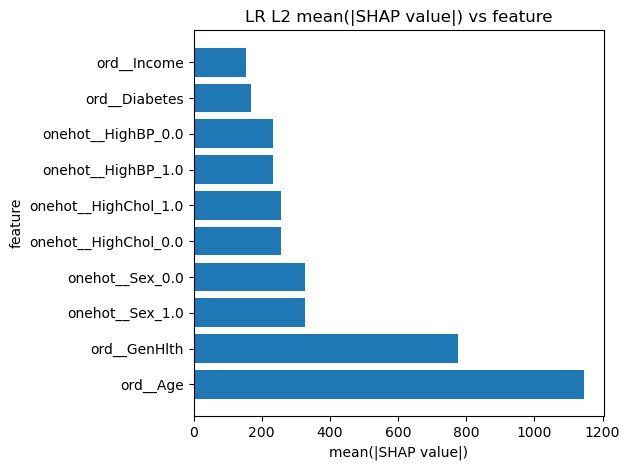

In [734]:
grid = lr_best_models[np.argmax(lr_test_scores)]

shap_summary = np.sum(np.abs(shap_values[:,:,1]),axis=0)+np.sum(np.abs(shap_values[:,:,0]),axis=0)

indcs = np.argsort(shap_summary)
print(shap_summary)

feature_names = grid.best_estimator_[0].get_feature_names_out()
print(feature_names)

plt.barh(feature_names[indcs[-1:-11:-1]],shap_summary[indcs[-1:-11:-1]])
plt.xlabel('mean(|SHAP value|)')
plt.ylabel('feature')
plt.title('LR L2 mean(|SHAP value|) vs feature')
plt.tight_layout()
plt.savefig('LR_L2_meanSHAP.png',dpi=300)
plt.show()
plt.show()

[-0.42557964  0.96356855  0.93937809 -0.4780042  -0.43000271 -0.48658693
  0.97211632  0.86619119 -0.86619119 -1.1652521   1.1652521  -0.19722843
  0.19722843 -1.11962348  1.11962348  0.20559395 -0.20559395 -0.56763153
  0.56763153  1.31717996 -1.31717996 -0.48195388  0.48195388  0.24383609
 -0.24383609 -0.22717019  0.22717019  0.30364344 -0.30364344 -2.22500365
  2.22500365 -1.12780326  1.12780326 -0.66203897]


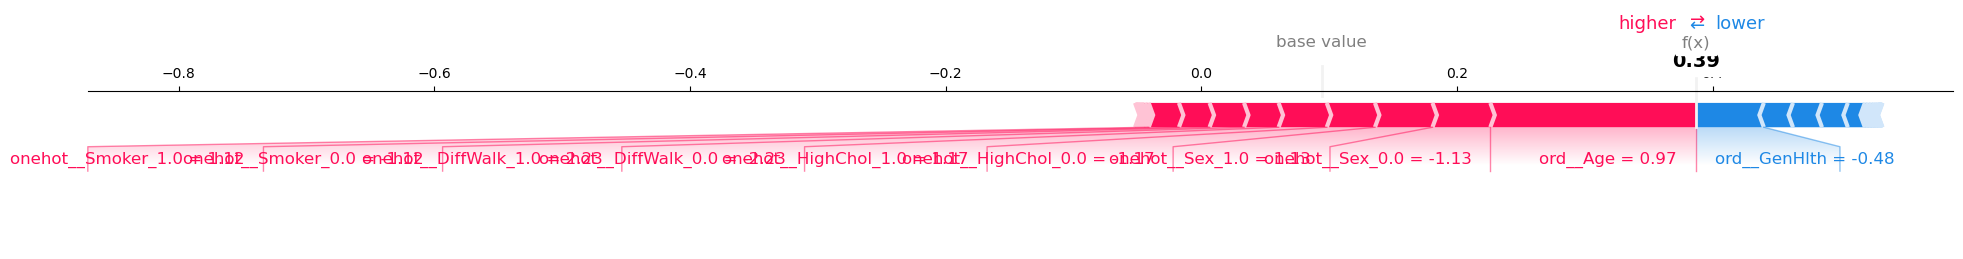

In [754]:
shap.initjs()

print(X_test_transformed[index,:])
shap.force_plot(len(y_test[y_test==1])/len(y_test), shap_values[index,:,1], 
                features = np.round(X_test_transformed[index,:],2),feature_names = feature_names,
                matplotlib=True,show=False)
plt.tight_layout()
plt.savefig("0_shap_force.png",dpi=300)
plt.show()

[-0.42557964 -0.05076952  0.45635964 -0.4780042  -0.43000271 -0.25709481
 -0.00997722  0.86619119 -0.86619119 -1.1652521   1.1652521  -0.19722843
  0.19722843  0.8931574  -0.8931574   0.20559395 -0.20559395 -0.56763153
  0.56763153 -0.7591977   0.7591977  -0.48195388  0.48195388  0.24383609
 -0.24383609 -0.22717019  0.22717019  0.30364344 -0.30364344  0.44943747
 -0.44943747  0.88667947 -0.88667947 -0.96457661]


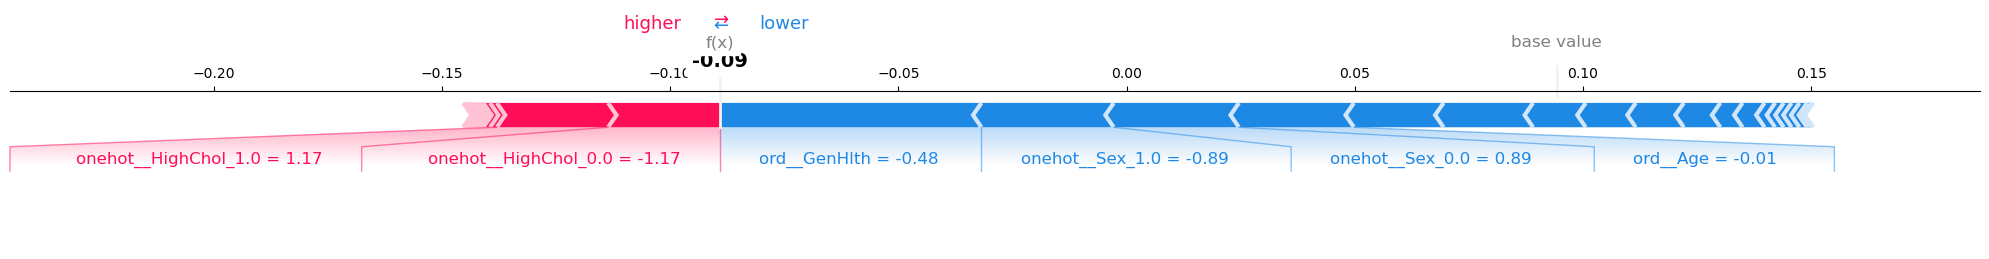

In [753]:
index = 200
print(X_test_transformed[index,:])
shap.force_plot(len(y_test[y_test==1])/len(y_test), shap_values[index,:,1], 
                features = np.round(X_test_transformed[index,:],2),feature_names = feature_names,
                matplotlib=True,show=False)
plt.tight_layout()
plt.savefig("200_shap_force.png",dpi=300)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


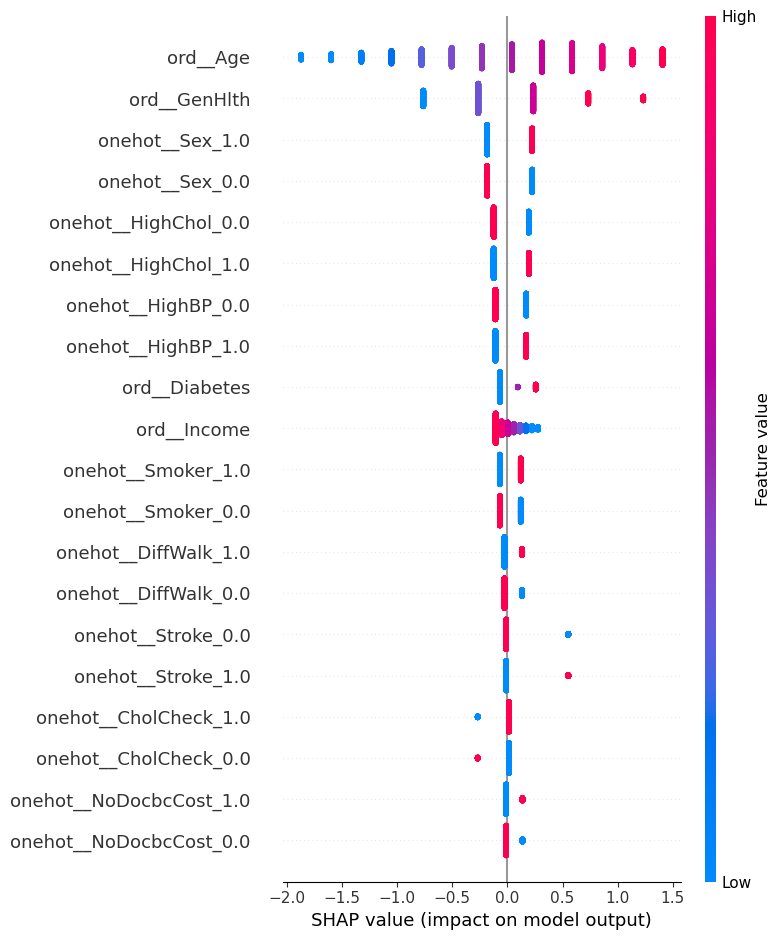

In [577]:
shap.summary_plot(shap_values, X_test_transformed[:],feature_names = feature_names)